# IMPORTS

## Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import glob
import os                                 # for os independent functions
#import seaborn as sns                     # for kernal density estimation
import datetime as dt                     # for naming files
from scipy.special import expit           # for logistic function
from scipy.stats import binned_statistic  # for binning RT vals
from scipy import stats
import sys
import importlib                          # in order to reload edited modules
import itertools                          # for creating values list (for aDDM of all stimuli value combos)
import time
import shelve
import pickle
#from tqdm import tqdm                     # for keeping track of progress
import pdb                                # for debugging use: pdb.set_trace()
import copy                               # to do deep copies

# display matplotlib graphs 
%matplotlib inline   
# %precision %.8f check on this...

print(sys.version)

/home/c/chutcher/wilsodj/.conda/envs/Python2_MADE/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


2.7.14 | packaged by conda-forge | (default, Oct  5 2017, 14:19:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


## GNUPLOT

Not necessary

In [21]:
from Gnuplot import Gnuplot as gplot
from Gnuplot import Data as gdata
from Gnuplot import Func as gfunc
g = gplot(persist = 1)

## Ex-Gaussian Utilities

---

[Paper](https://www.groundai.com/project/exgutils-a-python-package-for-statistical-analysis-with-the-ex-gaussian-probability-density/) on library ExGUtils.

In [2]:
#CHANGES
#drand_exp is now called exp_rvs, drand_gauss -> gauss_rvs and drand_exg -> exg_rvs

#from ExGUtils.pyexg import stats, drand, drand_exp, drand_gauss, drand_exg
from ExGUtils.pyexg import stats, drand, exp_rvs, gauss_rvs, exg_rvs
from ExGUtils.pyexg import *

In [4]:
# not working
from ExGUtils.uts import stats, drand, drand_exp, drand_gauss, drand_exg
from ExGUtils.uts import *

ImportError: No module named uts

# Exercises

## Listing 2

In [3]:
N = 1000000
mu = 100.; sig = 50.; tau = 150.
li1 = [drand() for ii in xrange(N)]
li2 = [exp_rvs(tau) for ii in xrange(N)]
li3 = [gauss_rvs(mu, sig) for ii in xrange(N)]
li4 = [exg_rvs(mu, sig , tau) for ii in xrange(N)]

# After each result , the expected value in parenthesis

[M, S, t] = stats(li1, True) 
print "Homogeneous:_M=%4.4f_(%4.4f)__S=%4.4f_(%4.4f)___t=%4.4f_(%4.4f)" %\
(M, 0.5 , S, (1./12)**.5 , t, 0.)

[M, S, t] = stats(li2, True) 
print "Exponential:_M=%4.4f_(%4.4f)__S=%4.4f_(%4.4f)___t=%4.4f_(%4.4f)" %\
(M, tau , S, tau , t, 2)

[M, S, t] = stats(li3, True) 
print "Gaussian:_M=%4.4f_(%4.4f)__S=%4.4f_(%4.4f)___t=%4.4f_(%4.4f)" %\
(M, mu , S, sig , t, 0.)

[M, S, t] = stats(li4, True) 
print "Ex-Gaussian:_M=%4.4f_(%4.4f)__S=%4.4f_(%4.4f)___t=%4.4f_(%4.4f)" %\
(M, mu+tau , S, (sig**2+tau**2)**.5 , t, 2.*(tau**3)/((sig**2+tau**2)**(3./2.)))



Homogeneous:_M=0.4997_(0.5000)__S=0.2888_(0.2887)___t=0.0019_(0.0000)
Exponential:_M=150.0346_(150.0000)__S=150.0358_(150.0000)___t=2.0033_(2.0000)
Gaussian:_M=100.0116_(100.0000)__S=50.0197_(50.0000)___t=0.0022_(0.0000)
Ex-Gaussian:_M=249.8946_(250.0000)__S=158.1552_(158.1139)___t=1.7159_(1.7076)


##  Histogram

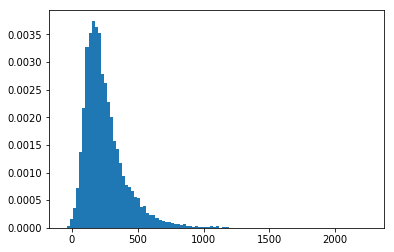

In [30]:
N = 10000
mu = 100.; sig = 50.; tau = 150.
li4 = [exg_rvs(mu, sig , tau) for ii in xrange(N)]

y,x, patches = plt.hist(li4, bins=100, density=True) # normed to make pdf (area = 1)
y2 = [exg_pdf(xi, mu, sig, tau) for xi in x]

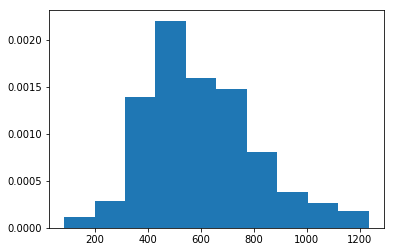

In [5]:
plt.hist(xi, density = True);

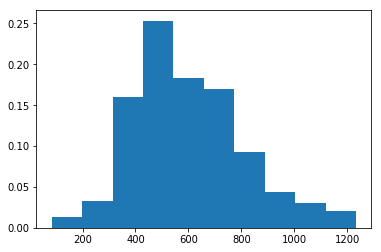

In [6]:
weights = np.ones_like(xi)/float(len(xi))
plt.hist(xi, weights=weights);

In [7]:
#plt.hist(xi, 50)
plt.plot(xx,ycs)
plt.plot(xx, ylk)

NameError: name 'xx' is not defined

ValueError: too many values to unpack

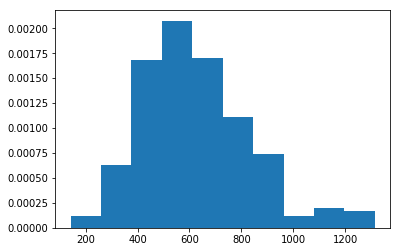

In [101]:
#[xx, yy] = histogram(xi , norm=1)
[xx, yy] = plt.hist(xi, density=1)
[mcs, scs, tcs] =minSQR(xx, yy)
[mlk, slk, tlk] =maxLKHD(xi)

ycs = [exg_pdf(x, mcs, scs, tcs) for x in xx]
ylk = [exg_pdf(x, mlk, slk, tlk) for x in xx]

d1 = gdata(xx, yy, with_="boxes", title="Histogram")
d2 = gdata(xx, ycs, with_="lines lw 2", title="minSQR")
d3 = gdata(xx, ylk, with_="lines lw 2", title="maxLKHD")

#g.plot(d1, d2, d3)

print "by maxLKHD: mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mlk, slk , tlk)
print "by minSQR : mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mcs, scs , tcs)


# Experimental Data

### Import Fixation Data

In [6]:
fixations = pd.read_csv("data/made_v2/fixations.csv")

### Create Middle and First Fixes (group and individual)

In [7]:
np.unique(fixations.parcode)

array([ 1,  3,  7,  8,  9, 11, 12, 15, 18, 19, 23, 29, 30, 31, 32, 33, 35,
       36, 37, 38, 39, 41, 43])

In [8]:
# GROUP
group_first_fix = fixations['fix_time'][fixations['fix_num']==1]
group_mid_fix = fixations['fix_time'][(fixations['fix_num']>1) & (fixations['rev_fix_num']>1)]

In [9]:
# INDIVIDUAL
subj_first_fix = {}
subj_mid_fix = {}

for i in np.unique(fixations.parcode):
    subj_first_fix[i] = fixations['fix_time'][(fixations['fix_num']==1) & (fixations['parcode']==i)]
    subj_mid_fix[i] = fixations['fix_time'][(fixations['fix_num']>1) & (fixations['rev_fix_num']>1) & (fixations['parcode']==i)]

In [10]:
fixations.head()

,Unnamed: 0,parcode,trial,fix_item,fix_time,fix_num,rev_fix_num
0,0,1,1,2,2850.349235,1,6
1,1,1,1,1,1233.176509,2,5
2,2,1,1,2,433.403406,3,4
3,3,1,1,1,433.219029,4,3
4,4,1,1,2,1233.325697,5,2


In [11]:
grouped = fixations.groupby('parcode')


In [12]:
subj_first_fix[1].sem()


51.932134242376655

In [13]:
# First Fixation
parcode = []
first_fix_mean = []
first_fix_sem = []
mid_fix_mean = []
mid_fix_sem = []

for subject, subject_data in grouped:
    parcode.append(subject)
    first_fix_mean.append(subject_data.fix_time[subject_data.fix_num==1].mean())
    first_fix_sem.append(subject_data.fix_time[subject_data.fix_num==1].sem())
    mid_fix_mean.append(subject_data.fix_time[(subject_data.fix_num>1) & (subject_data.rev_fix_num>1)].mean())
    mid_fix_sem.append(subject_data.fix_time[(subject_data.fix_num>1) & (subject_data.rev_fix_num>1)].sem())


In [14]:
fix_df = pd.DataFrame(
    {'subject': parcode,
     'first_fix_mean': first_fix_mean,
     'first_fix_sem': first_fix_sem,
     'mid_fix_mean': mid_fix_mean,
     'mid_fix_sem': mid_fix_sem
    })


In [15]:
fix_df.head()


,first_fix_mean,first_fix_sem,mid_fix_mean,mid_fix_sem,subject
0,1090.045539,51.932134,959.203733,35.661796,1
1,759.135110,48.079921,958.895330,27.699928,3
2,581.674742,25.100458,1993.624838,287.979926,7
3,825.557328,44.542549,983.645981,44.327489,8
4,826.477506,40.212693,845.862021,23.738707,9


## Individual vs. Group First Fix RT

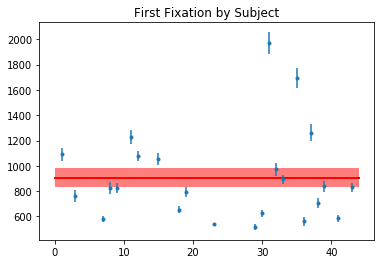

In [16]:
group_first_fix_mean = np.repeat(fix_df.first_fix_mean.mean(), 45, axis=0)
group_first_fix_sem = np.repeat(fix_df.first_fix_mean.sem(), 45, axis=0)
x = np.arange(45)

plt.errorbar(fix_df.subject, fix_df.first_fix_mean, fix_df.first_fix_sem, linestyle='None', marker='.')
plt.plot(x, group_first_fix_mean, lw=2, label='mean population 1', color='red')
plt.fill_between(x, group_first_fix_mean+group_first_fix_sem, group_first_fix_mean-group_first_fix_sem,
                 facecolor='red', alpha=0.5)
plt.title('First Fixation by Subject')


plt.show()


## Individual vs. Group Middle Fix RT

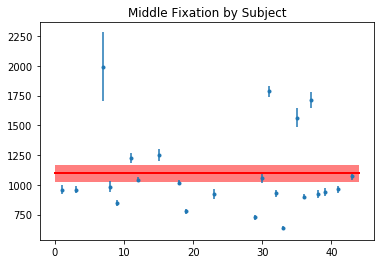

In [17]:
group_mid_fix_mean = np.repeat(fix_df.mid_fix_mean.mean(), 45, axis=0)
group_mid_fix_sem = np.repeat(fix_df.mid_fix_mean.sem(), 45, axis=0)
x = np.arange(45)

plt.errorbar(fix_df.subject, fix_df.mid_fix_mean, fix_df.mid_fix_sem, linestyle='None', marker='.')
plt.plot(x, group_mid_fix_mean, lw=2, label='mean population 1', color='red')
plt.fill_between(x, group_mid_fix_mean+group_mid_fix_sem, group_mid_fix_mean-group_mid_fix_sem,
                 facecolor='red', alpha=0.5)
plt.title('Middle Fixation by Subject')

plt.show()

In [18]:
print "MEAN"
print subj_mid_fix[1].mean()
print "LENGTH"
print len(subj_mid_fix[1])

subj_mid_fix[1].head()

MEAN
959.2037329943817
LENGTH
376


1    1233.176509
2     433.403406
3     433.219029
4    1233.325697
7    1183.183932
Name: fix_time, dtype: float64

In [35]:
xi = subj_mid_fix[15].values.tolist()

In [36]:
[xx, yy] = histogram(xi , norm=1)
[mcs, scs, tcs] =minSQR(xx, yy)
[mlk, slk, tlk] =maxLKHD(xi)

ycs = [exgauss(x, mcs, scs, tcs) for x in xx]
ylk = [exgauss(x, mlk, slk, tlk) for x in xx]

d1 = gdata(xx, yy, with_="boxes", title="Histogram")
d2 = gdata(xx, ycs, with_="lines lw 2", title="minSQR")
d3 = gdata(xx, ylk, with_="lines lw 2", title="maxLKHD")

g.plot(d1, d2, d3)

print "by maxLKHD: mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mlk, slk , tlk)
print "by minSQR : mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mcs, scs , tcs)

NameError: name 'exgauss' is not defined

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(xi, 50, normed=1, facecolor='yellow', alpha=0.75)

# add a 'best fit' line
#l = plt.plot(xx, ycs, 'r--', linewidth=1) # least squares
l2 = plt.plot(xx, ylk, 'b--', linewidth=1) # max likelihood
l_group = plt.plot(xx_group,ylk_group, 'g--', linewidth=1)

plt.xlabel('RT in ms')
plt.ylabel('Probability')
plt.title('Middle Fixation')
plt.axis([0, 3500, 0, 0.002])

plt.show()


In [19]:
xi_group = group_mid_fix.values.tolist()

In [20]:
# group fit
[xx_group, yy_group] = histogram(xi_group , norm=1)
[mcs, scs, tcs] =minSQR(xx_group, yy_group)
[mlk, slk, tlk] =maxLKHD(xi_group)

ycs_group = [exgauss(x, mcs, scs, tcs) for x in xx_group]
ylk_group = [exgauss(x, mlk, slk, tlk) for x in xx_group]

print "by maxLKHD: mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mlk, slk , tlk)
print "by minSQR : mu=%3.4f , sig=%3.4f , tau=%3.4f"%(mcs, scs , tcs)

by maxLKHD: mu=453.5634 , sig=157.6098 , tau=561.5854
by minSQR : mu=498.4341 , sig=203.4021 , tau=443.8988


## HISTOGRAM

In [46]:
N = 10000
mu = 100.; sig = 50.; tau = 150.

li4 = [drand_exg(mu, sig , tau) for ii in xrange(N)]

[x, y] = histogram(li4 , norm=1)

y2 = [exgauss(xi, mu, sig, tau) for xi in x]
d1 = gdata(x, y2, with_="lines lw 3 lc 1", title="exgaussian") 
d2 = gdata(x, y, with_="boxes lc 3", title="histogram") 
g.plot(d1, d2)

M, S, t = stats(li4, 1)
print "Li4 stats : M = %f , S = %f , t = %f "%(M, S, t)
[x, y] = histogram(li4 , norm=0)

M1, S1, t1 = stats_his(x, y, assymetry=True)
print "For norm=0 : M=%f, S =%f, t =%f sum(yi) =%f"%(M1, S1, t1, sum(y))
[x, y] = histogram(li4 , norm=-1)

M1, S1, t1 = stats_his(x, y, assymetry=1, norm=-1, N=N)
print "For norm=−1: M=%f, S =%f, t =%f sum(yi) =%f"%(M1, S1, t1, sum(y))
[x, y] = histogram(li4 , norm=1)

M1, S1, t1 = stats_his(x, y, assymetry=1, norm=1, N=N)
print "For norm=1 : M = %f , S = %f , t = %f sum(yi∗dx) = %f"%(M1, S1, t1 , sum(y)*(x[1]-x[0]))


Li4 stats : M = 250.009063 , S = 158.059525 , t = 1.740103 
For norm=0 : M=249.985470, S =158.045049, t =1.738630 sum(yi) =10000.000000
For norm=−1: M=249.985470, S =158.045049, t =1.738630 sum(yi) =1.000000
For norm=1 : M = 249.985470 , S = 158.045049 , t = 1.738630 sum(yi∗dx) = 1.000000


In [9]:
%gnuplot inline


ERROR:root:Line magic function `%gnuplot` not found.
